## Reinforcement Learning Solution to the Ant-Hill Problem

Note: Here, we are trying to learn an optimal path for ant to reach reward (food).....

In [28]:
!pip install shimmy

In [29]:
!pip install stable-baselines3 gym matplotlib numpy

In [30]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from gym import spaces

In [31]:
from stable_baselines3.common.callbacks import BaseCallback

class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggerCallback, self).__init__(verbose)
        self.rewards = []

    def _on_step(self) -> bool:
        self.rewards.append(self.locals["rewards"])
        return True

In [35]:
class CustomEnv(gym.Env):
    """A simple 2D grid environment"""
    metadata = {'render.modes': ['console']}

    def __init__(self):
        super(CustomEnv, self).__init__()
        self.action_space = spaces.Discrete(4)  # Four directions
        # Define observation space within the grid limits
        self.observation_space = spaces.Box(low=np.array([-100, -100]), high=np.array([100, 100]), dtype=np.float32)   # Random Assignment of Boundary of our 2d World
        self.food_pos = [np.array([2., 2.])] #, np.array([-2., -2.]), np.array([2., -2.]), np.array([-2., 2.])]  # Food_positions
        self.state = np.zeros(2)  # Initialize the agent's position

    def reset(self):
        self.state = np.zeros(2)  # Reset the ant's position to the center after each episode
        return self.state

    def step(self, action):
        # Apply action
        if action == 0:  # Up
            self.state[1] += 1
        elif action == 1:  # Down
            self.state[1] -= 1
        elif action == 2:  # Left
            self.state[0] -= 1
        elif action == 3:  # Right
            self.state[0] += 1

        # Ensure the ant's position does not exceed the grid boundaries
        self.state = np.clip(self.state, self.observation_space.low, self.observation_space.high)

        # Calculate the distance to food
        distance_to_food = np.linalg.norm(self.state - self.food_pos)

        # Check if the ant has reached food
        done = bool(np.array_equal(self.state, self.food_pos))
        reward = 1 if done else -distance_to_food / 100.0  # Reward is higher as the ant approaches food
         # This makes the agent learn faster and explore more from the get go!

        return self.state, reward, done, {}

    def render(self, mode='console'):
        if mode != 'console':
            raise NotImplementedError()
        print(f"Agent position: {self.state}")

# Create the environment
env = make_vec_env(lambda: CustomEnv(), n_envs=1)

# Instantiate the agent (ant)
model = PPO("MlpPolicy", env, verbose=1)

# Train the agent
model.learn(total_timesteps=50000)

# Test the agent
obs = env.reset()
done = False
rewards = []  # Initialize a list to store rewards
x_coords, y_coords = [obs[0][0]], [obs[0][1]]  # Initialize lists to store positions

max_steps = 1000  # Set a maximum number of steps per episode
current_step = 0  # Initialize the current step count

while not done and current_step < max_steps:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    rewards.append(reward)  # Log the reward
    x_coords.append(obs[0][0])
    y_coords.append(obs[0][1])
    current_step += 1  # Increment the step count

    if done.any():  # Adjusted for vectorized environments
        break


Using cuda device
-----------------------------
| time/              |      |
|    fps             | 728  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 557         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010315925 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.173       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.16        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00461    |
|    value_loss           | 2.72        |
-----------------------------------------
----------------

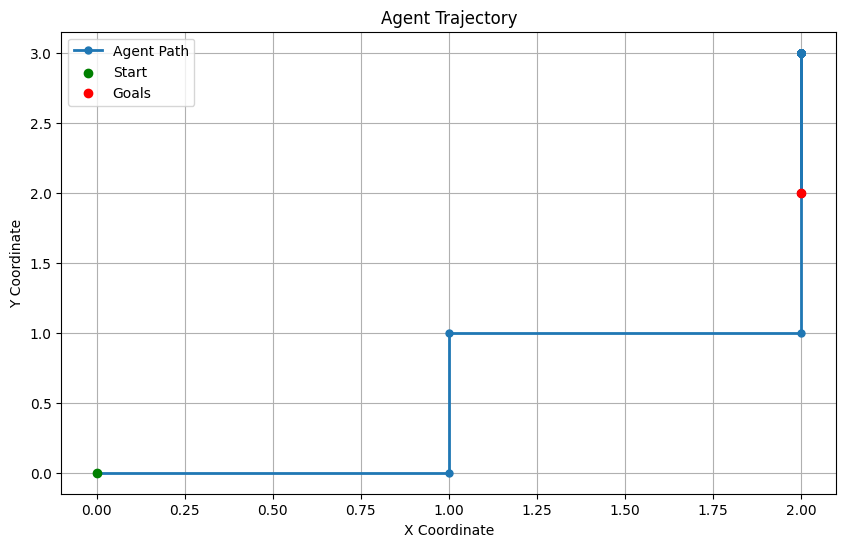

In [36]:
# Plotting the trajectory
plt.figure(figsize=(10, 6))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', markersize=5, linewidth=2, label='Agent Path')
plt.scatter([0], [0], color='green', label='Start', zorder=5)
plt.scatter([2], [2], color='red', label='Goals', zorder=5)
plt.title('Agent Trajectory')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

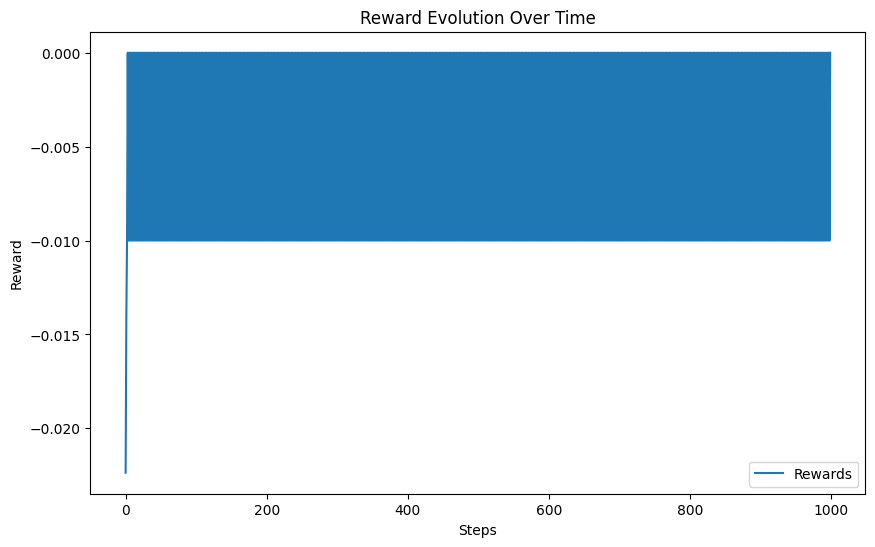

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(rewards, label='Rewards')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title('Reward Evolution Over Time')
plt.legend()
plt.show()